<p>First we will import packages needed for our analysis</p>

In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

df_raw = pd.read_csv('BankChurners.csv')
y = df_raw['Attrition_Flag'].to_numpy()

<h1>EDA</h1>

<p>We will investigate the features in our dataframe.  We have one column which we are trying to predict, it is labeled Attrited Customer.  For our data columns we have 14 numerical and 5 categorical.  I will build histograms of this data so we can see any general relationships in the data.  I have also included a heatmap of numerical variables to investigate any dependent variables.</p>

In [29]:

categorical = ['Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
numerical = ['Customer_Age', 'Dependent_count','Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

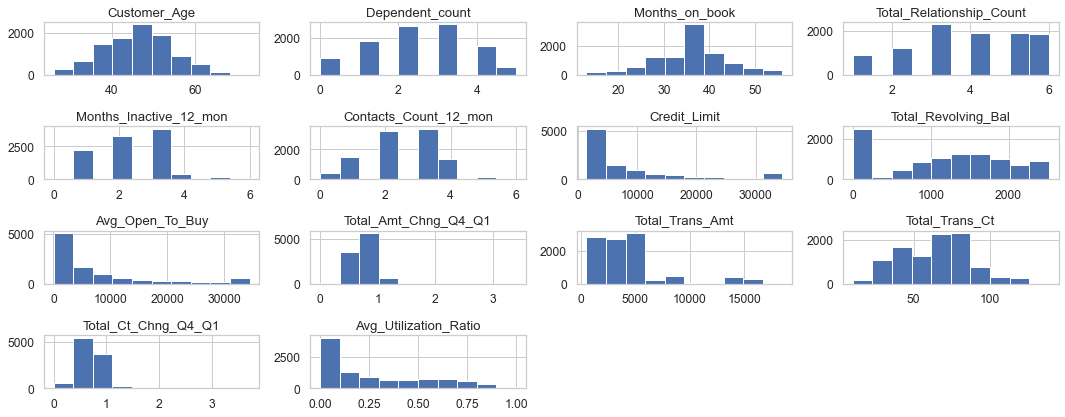

In [30]:
import seaborn as sns

sns.set(style='whitegrid',palette='deep',font_scale=1.1, rc={'figure.figsize': [8,5]})

tr = df_raw[numerical].hist(figsize=(15,6))
plt.tight_layout()
plt.show()

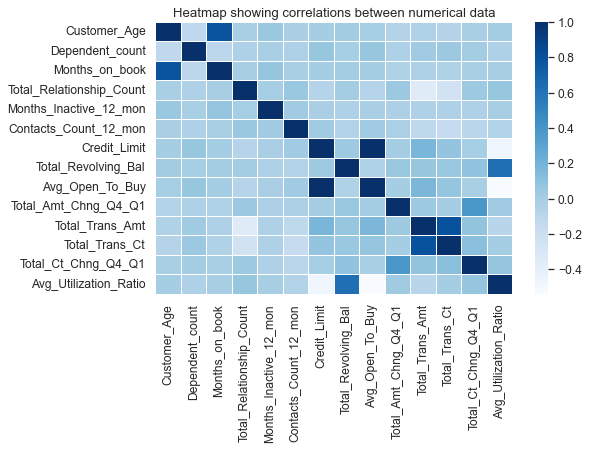

In [31]:
sns.heatmap(df_raw[numerical].corr(),annot=False,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

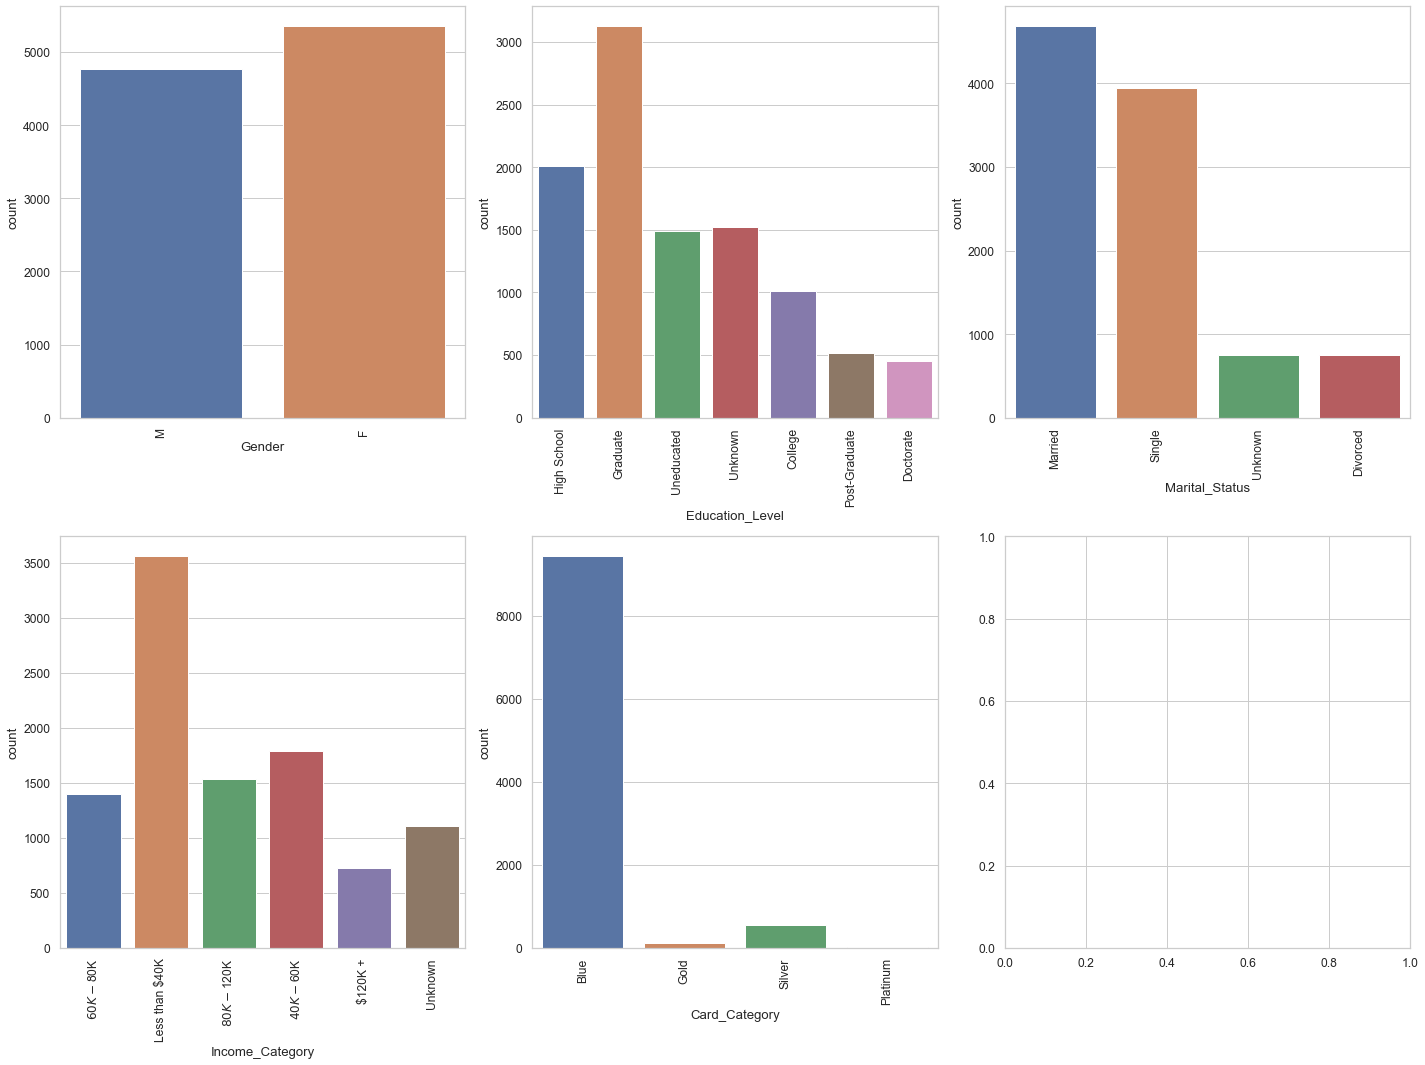

In [32]:
fig, ax = plt.subplots(2,3,figsize=(20,15))

for variable, subplot in zip(categorical,ax.flatten()):
    sns.countplot(df_raw[variable],ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

plt.tight_layout()
plt.show()

<p>It seems as if there is an endless amount of EDA that can be done.  We can have hypothesis tests and even a whole readable report for each variable and its effects on this model.  I have found endless different graphs that may be used to visualize this data.  The most useful that I have seen for this is to make the same plots for attrited and existing customers and examine the differences.</p>

<p>We must construct our data matrix, $X$.  For our categorical data I will hot encode it into our feature matrix $X$.  The remaining columns are all numerical and pertain to credit card use data that has been compiled.  The data is very clean therefore very little pre-processing is required.  In the end we have a feature matrix with 36 columns and 10,127 rows for data entries.</p>

In [33]:
cols = df_raw.describe().columns
cols = cols.tolist()
dfx = df_raw[cols[1:-2]]
X_num = dfx.to_numpy()

# Gender, categorical
df_gender = pd.get_dummies(df_raw['Gender'])
genF = df_gender['F'].to_numpy()
Xf = np.append(X_num,genF.reshape((10127,1)),axis=1)

# Education, categorical
df_edu = pd.get_dummies(df_raw['Education_Level'])
edu = df_edu.to_numpy()
# print(edu.shape)
Xed = np.append(Xf,edu,axis=1)

# Marriage, categorical
mar = df_raw['Marital_Status'].unique()
df_mar = pd.get_dummies(df_raw['Marital_Status'])
mar = df_mar.to_numpy()
Xmar = np.append(Xed,mar,axis=1)

# Income, categorical
inc = df_raw['Income_Category'].unique()
df_inc = pd.get_dummies(df_raw['Income_Category'])
df_inc.head()
inc = df_inc.to_numpy()
Xinc = np.append(Xmar,inc,axis=1)

# Card Category, categorical
cc = df_raw['Card_Category'].unique()
df_cc = pd.get_dummies(df_raw['Card_Category'])
df_cc.tail()
cc = df_cc.to_numpy()
Xcc = np.append(Xinc,cc,axis=1)

# Final X, just rename
X = Xcc

In [34]:
def custom_recall_score(y_test, y_pred):
    return metrics.recall_score(y_test,y_pred, average=None)[0]

c_score = make_scorer(custom_recall_score)
X.shape

(10127, 36)

<p>Our preprocessing involves splitting our data entries into test and train sets.  Then we must transfom this to standardize the mean and variance.  This is to ensure one column does not dominate the model since its mean is very high compared to other columns.</p>

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=53)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

<h3>First Model is the Logistic Regression - 55<h3>

In [36]:
logreg = LogisticRegression(random_state=53)
y_pred = logreg.fit(X_train,y_train).predict(X_test)

print("Recall:",metrics.recall_score(y_test,y_pred, average=None)[0])

Recall: 0.5537757437070938


<h3>Second Model is the Tuned Logistic Regression - 56<h3>

In [37]:
parameters = {
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
}

clf = GridSearchCV(logreg,
                   param_grid = parameters,
                   scoring=c_score,
                   verbose=0)

clf.fit(X_train,y_train)
print("Tuned Hyperparameters :", clf.best_params_)
print("Recall :",clf.best_score_)

Tuned Hyperparameters : {'C': 100.0, 'solver': 'newton-cg'}
Recall : 0.5722689075630252


In [38]:
#logreg = LogisticRegression(C = 1.0, solver = 'lbfgs') # <---Defaults
logreg = LogisticRegression(C = 100.0, solver = 'newton-cg',random_state=53)
y_pred = logreg.fit(X_train,y_train).predict(X_test)
print("Recall:",metrics.recall_score(y_test,y_pred, average=None)[0])

Recall: 0.5560640732265446


<h3>Third Model is the Naive Bayes Classifier - 55<h3>

In [39]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print("Recall:",metrics.recall_score(y_test,y_pred, average=None)[0])

Recall: 0.5469107551487414


<h3>Fourth Model is the Tuned Naive Bayes Classifier - 54, Somehow Worse<h3>

In [40]:
param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

nbModel_grid = GridSearchCV(estimator=GaussianNB(), 
                            param_grid=param_grid_nb, 
                            scoring=c_score,
                            verbose=0)# verbose = 3 to read output

nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)
print("Recall :",nbModel_grid.best_score_)

GaussianNB(var_smoothing=0.003511191734215131)
Recall : 0.5907563025210084


In [41]:
#gnbh = GaussianNB(var_smoothing=0.000000001)  <--- Defaults
gnbh = GaussianNB(var_smoothing=0.003511191734215131)
y_pred = gnbh.fit(X_train, y_train).predict(X_test)

print("Recall:",metrics.recall_score(y_test,y_pred, average=None)[0])

Recall: 0.5446224256292906


<h3>Fifth Model is the Random Forest Classifier - 69<h3>

In [42]:
clf = RandomForestClassifier(max_depth=8, random_state=53)
clf.fit(X_train, y_train) #< fit on the train, predict on the test
y_pred = clf.predict(X_test)
print("Recall:",metrics.recall_score(y_test,y_pred, average=None)[0])

Recall: 0.6864988558352403


<h3>Sixth Model is the Tuned Random Forest Classifier - 81, 62<h3>

<p>I have employed two methods to tune this model.  The first is a grid search of parameters.  This tests a set of parameters exhaustively.  This is time consuming which is why I did the second.  This is the largest range of parameters I would choose for this because of the long runtime to exhaust all posibilities.  The second method is random search which can take more parameters but does not systematically test each one.  This search runs fast and we hope to find an acceptable parameter solution in much less time than the gridsearch method.</p>

In [43]:
param_grid_rf = {
    'bootstrap': [True],
    'max_depth': [80, 110],
    'max_features': ['auto', 3],
    'min_samples_leaf': [1,3],
    'min_samples_split': [2, 8],
    'n_estimators': [100, 1000]
}

#  This takes 10 minutes
rf_model_grid = GridSearchCV(estimator=RandomForestClassifier(),
                            param_grid=param_grid_rf, 
                            scoring=c_score,
                            verbose=0)
rf_model_grid.fit(X_train, y_train)
print(rf_model_grid.best_estimator_)
print("Recall :",rf_model_grid.best_score_)

RandomForestClassifier(max_depth=110)
Recall : 0.7857142857142857


In [45]:
clf_h = RandomForestClassifier(max_depth=110, random_state=53)
y_pred = clf_h.fit(X_train, y_train).predict(X_test)
print("Recall:",metrics.recall_score(y_test,y_pred, average=None)[0])

# Previously I had this output from the above, got and 0.80549 recall score
# clf_h = RandomForestClassifier(max_depth=80,
#                                n_estimators=1000, # take this out to get a better score
#                                random_state=53)
# y_pred = clf_h.fit(X_train, y_train).predict(X_test)
# print("Recall:",metrics.recall_score(y_test,y_pred, average=None)[0])

Recall: 0.8077803203661327


In [46]:
param_dist = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [2, 3, 4, 5, 8],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

n_iter_search = 10
rf_random_search = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                   param_distributions=param_dist,
                                   scoring=c_score,
                                   verbose=0,
                                   n_iter=n_iter_search)


rf_random_search.fit(X_train, y_train)
print(rf_random_search.best_estimator_)
print("Recall :",rf_random_search.best_score_)

RandomForestClassifier(max_depth=110, max_features=3, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=1000)
Recall : 0.6042016806722689


In [48]:
clf_h = RandomForestClassifier(max_depth=100,
                               max_features=3,
                               min_samples_leaf=3,
                               min_samples_split=10,
                               n_estimators=1000,
                               random_state=53)
y_pred = clf_h.fit(X_train, y_train).predict(X_test)

print("Recall:",metrics.recall_score(y_test,y_pred, average=None)[0])

# Previous Result --> 0.6247 result
# clf_h = RandomForestClassifier(max_depth=100,
#                                max_features=3,
#                                min_samples_leaf=2,
#                                min_samples_split=10,
#                                n_estimators=300,
#                                random_state=53)
# y_pred = clf_h.fit(X_train, y_train).predict(X_test)

# print("Recall:",metrics.recall_score(y_test,y_pred, average=None)[0])

Recall: 0.6086956521739131


<h3>Questions</h3>
<ol>
  <li>Second Model - Tuned LogReg - Why does result of GridSearch give recall of 57.2, when I run it is 55.6?  best_score != model recall score</li>
  <li>Second Model - Tuned LogReg - With verbose = 3 we have lines like this which are better, but not result given?</br>[CV 4/5] END .........C=100.0, solver=liblinear;, score=0.601 total time=   0.0s</li>  
  <li>Fourth Model - Tuned NB - How could GridSearch have found a worse Answer?</li>
  <li>What am I supposed to learn from the heatmap? I think it is to find linearly dependent columns to maybe decrease the number of columns in our feature matrix $X$.</li>
  <li>What is the appropriate amount of EDA for this project? Should this turn into an essay?</li>
</ol>